In [1]:
# Library imports
import os
import re
import random
import logging
from tqdm import tqdm

# Libraries for data handling
import numpy as np
import pandas as pd

# Libraries for audio processing
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pydub import AudioSegment, effects

# Libraries for Modelling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Libraries for visualization
import seaborn as sns
from sklearn.metrics import confusion_matrix

2025-04-26 19:37:10.511803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745671030.625411 1178410 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745671030.658766 1178410 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-26 19:37:10.981791: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
root_dir = '../data/processed_audio' # the root directory of the dataset

emotion_dict = { # mapping of emotions to integers
    '01': 'neutral', 
    '02': 'happy',
    '03': 'suprised',
    '04': 'angry', 
    '05': 'sad',
}

intensity_dict = { # mapping of intensity to integers
    '01': 'normal',
    '02': 'strong',
}

repetition_dict = { # mapping of repetition to integers
    '01': 'first',
    '02': 'second',
    '03': 'third'
}

data = [] # list to store the data


for folder in tqdm(os.listdir(root_dir)):
    folder_path = os.path.join(root_dir, folder)
    
    # check if the folder is a directory
    if os.path.isdir(folder_path):
        # print(f"Processing folder: {folder}")
        
        for filename in os.listdir(folder_path):
            # print(f"Processing file: {filename}")
            
            if filename.endswith('.wav'):
                parts = filename.replace('.wav', '').split('-')
                
                actor_code = parts[0]
                emotion_code = parts[1]
                intensity_code = parts[2]
                repetition_code = parts[3]
                
                # print(f"Processing file: {filename}, actor: {actor}, emotion: {emotion}, intensity: {intensity}, repetition: {repetition}")
                
                actor_num = int(actor_code)
                gender = "male" if actor_num % 2 == 1 else "female"
                
                # Convert emotion code to integer
                emotion = emotion_dict.get(emotion_code, "unknown")
                intensity = intensity_dict.get(intensity_code, "unknown")
                repetition = repetition_dict.get(repetition_code, "unknown")
                
                data.append({
                    'emotion' : emotion,
                    'gender'  : gender,
                    # 'filename': filename,
                    'filepath': os.path.join(folder_path, filename),
                })    

100%|██████████| 11/11 [00:00<00:00, 6811.95it/s]


In [3]:
# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
csv_path = os.path.join(root_dir, 'metadata.csv')
df.to_csv(csv_path, index=False)
print(f"Metadata saved to {csv_path}")
# Display the first few rows of the DataFrame
print(df.head())

Metadata saved to ../data/processed_audio/metadata.csv
    emotion gender                                          filepath
0       sad   male  ../data/processed_audio/Actor_07/07-05-01-01.wav
1   neutral   male  ../data/processed_audio/Actor_07/07-01-02-02.wav
2     angry   male  ../data/processed_audio/Actor_07/07-04-02-01.wav
3     angry   male  ../data/processed_audio/Actor_07/07-04-01-03.wav
4  suprised   male  ../data/processed_audio/Actor_07/07-03-01-03.wav


In [4]:
# Display the distribution of emotions
emotion_counts = df['emotion'].value_counts()
print("Emotion distribution:")
print(emotion_counts)

Emotion distribution:
emotion
sad         60
neutral     60
angry       60
suprised    60
happy       60
Name: count, dtype: int64


### Audio Visualisation

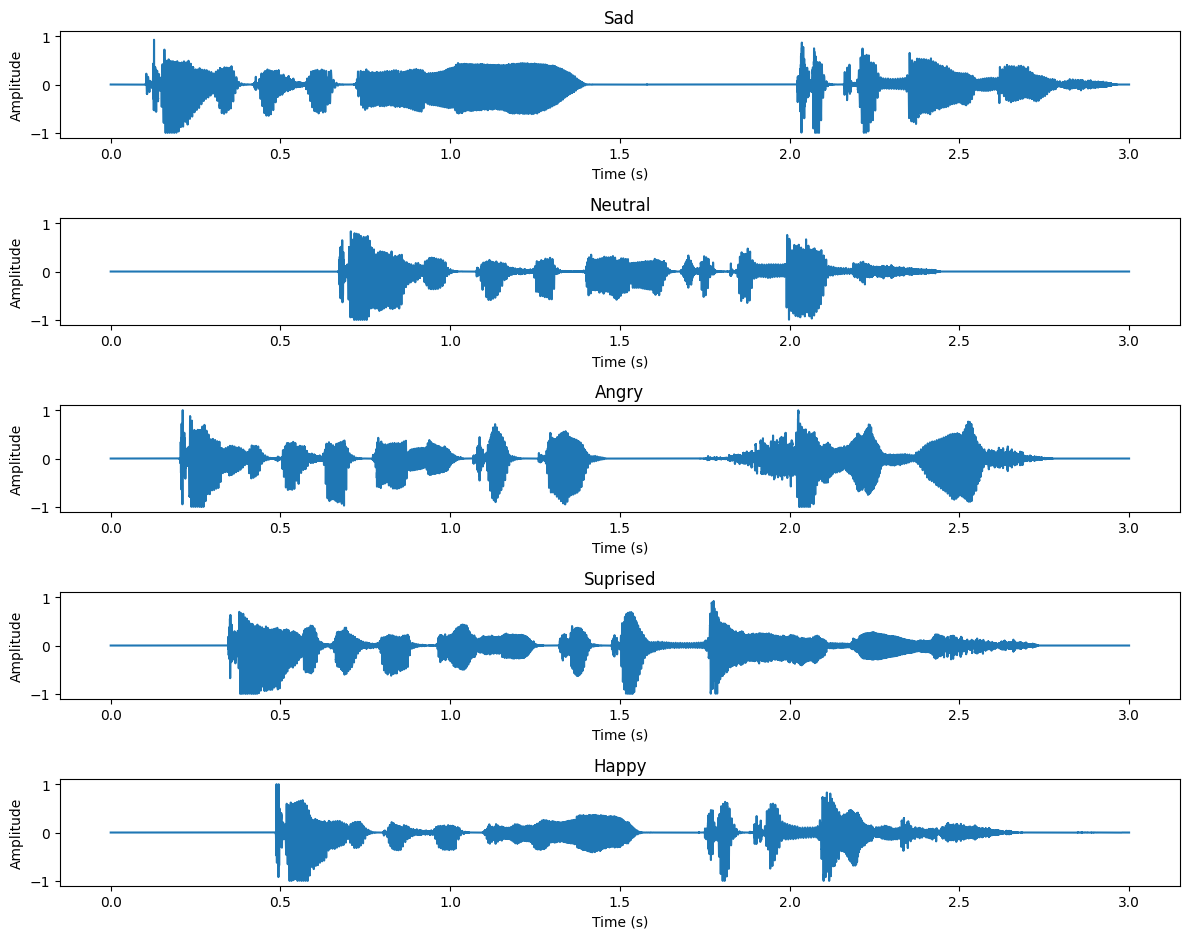

In [5]:
def visualize_emotions_raw(df):
    """
    Visualize raw audio waveforms for each emotion category
    
    Parameters:
    - df: DataFrame containing 'emotion' and 'filepath' columns
    """
    # Get unique emotions
    emotions = df['emotion'].unique()
    
    # Create figure with appropriate size for just waveforms
    fig = plt.figure(figsize=(12, 2*len(emotions)))
    
    # Set a title for the entire figure
    # fig.suptitle('Raw Audio Waveforms Berdasarkan Kategori Emosi', fontsize=16)
    
    # Process one sample from each emotion
    for i, emotion in enumerate(emotions):
        # Get first file path for this emotion
        sample_path = df[df['emotion'] == emotion]['filepath'].iloc[0]
        
        # Load raw audio without any preprocessing
        audio, sample_rate = librosa.load(sample_path, sr=None)  # sr=None preserves original sample rate
        
        # Plot waveform
        ax = plt.subplot(len(emotions), 1, i+1)  # Changed to one column layout
        time = np.linspace(0, len(audio)/sample_rate, len(audio))
        ax.plot(time, audio)
        plt.title(f'{emotion.capitalize()}')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.ylim([-1.1, 1.1])  # Standard amplitude range
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the title
    return fig

# Call the function with your DataFrame
fig = visualize_emotions_raw(df)
plt.savefig('../saves/emotion_waveforms_visualization.png', dpi=300)
plt.show()

<Figure size 1200x600 with 0 Axes>

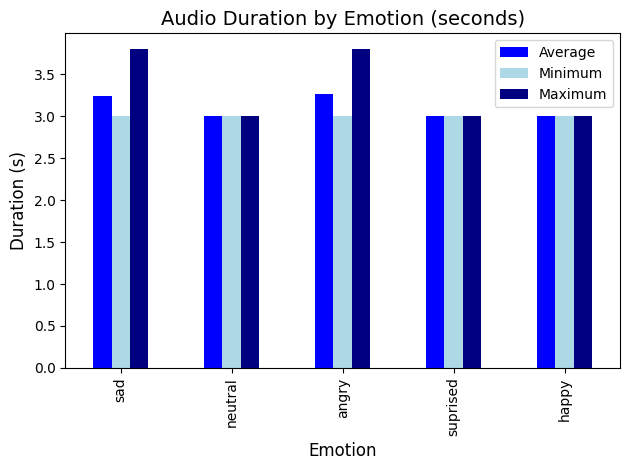

    emotion  avg_duration  min_duration  max_duration
0       sad      3.244973      2.999683      3.800000
1   neutral      2.999991      2.999569      3.000499
2     angry      3.270431      2.999683      3.800000
3  suprised      2.999992      2.999751      3.000431
4     happy      3.000010      2.999683      3.000499


In [6]:
def analyze_emotion_audio_statistics(df):
    """
    Analyze and visualize duration statistics of raw audio files grouped by emotion
    
    Parameters:
    - df: DataFrame containing 'emotion' and 'filepath' columns
    
    Returns:
    - DataFrame with audio statistics by emotion
    """
    # Get unique emotions
    emotions = df['emotion'].unique()
    
    # Prepare data storage
    stats = {
        'emotion': [],
        'avg_duration': [],
        'min_duration': [],
        'max_duration': []
    }
    
    # Process each emotion
    for emotion in emotions:
        # Get file paths for this emotion
        emotion_files = df[df['emotion'] == emotion]['filepath']
        
        durations = []
        
        # Process each file
        for file_path in emotion_files:
            # Load raw audio
            audio, sample_rate = librosa.load(file_path, sr=None)
            
            # Calculate duration
            duration = len(audio) / sample_rate
            durations.append(duration)
        
        # Store statistics
        stats['emotion'].append(emotion)
        stats['avg_duration'].append(np.mean(durations))
        stats['min_duration'].append(np.min(durations))
        stats['max_duration'].append(np.max(durations))
    
    # Create a DataFrame with statistics
    stats_df = pd.DataFrame(stats)
    
    # Create figure for duration plot
    plt.figure(figsize=(12, 6))
    
    # Duration plot
    ax = stats_df.plot(x='emotion', y=['avg_duration', 'min_duration', 'max_duration'], 
                kind='bar', color=['blue', 'lightblue', 'navy'])
    
    # Add value labels on top of bars
    # for container in ax.containers:
    #     ax.bar_label(container, fmt='%.2f', fontsize=9)
    
    plt.title('Audio Duration by Emotion (seconds)', fontsize=14)
    plt.xlabel('Emotion', fontsize=12)
    plt.ylabel('Duration (s)', fontsize=12)
    # plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(['Average', 'Minimum', 'Maximum'])
    
    plt.tight_layout()
    # plt.savefig('emotion_duration_statistics.png', dpi=300)
    plt.show()
    
    return stats_df

# Call the function with your DataFrame
stats_df = analyze_emotion_audio_statistics(df)
print(stats_df)

### Pre-processing Data & Feature Extraction

In [7]:
def noise(data):
    noise_amp = 0.05 * np.random.uniform() * np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

def resample_audio(data, original_sample_rate, target_sample_rate=16000):
    """
    Resamples the audio to a target sample rate.
    """
    return librosa.resample(data, orig_sr=original_sample_rate, target_sr=target_sample_rate)

def convert_to_mono(data):
    """
    Converts stereo audio to mono by averaging channels
    If already mono, returns the original data
    """
    if len(data.shape) > 1:
        return np.mean(data, axis=1)
    return data

def pitch_shift(data, sample_rate):
    """
    Shift the pitch by n_steps
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                       sample_rate, n_steps=pitch_change, 
                                       bins_per_octave=bins_per_octave)
    return data

def speedNpitch(data):
    """
    speed and Pitch Tuning.
    """
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

def normalize_audio(data):
    """
    Normalizes audio data to have values between -1 and 1
    """
    max_val = np.max(np.abs(data))
    if max_val > 0:
        return data / max_val
    return data

def trim_audio(data, threshold=0.01, frame_length=512):
    """
    Trim silence from beginning and end of audio data
    
    Parameters:
    - data: audio time series
    - threshold: threshold for considering as silence
    - frame_length: length of analysis frame in samples
    
    Returns:
    - trimmed audio time series
    """
    # Use librosa's trim function to remove silence
    trimmed_data, _ = librosa.effects.trim(data, top_db=20, 
                                         frame_length=frame_length, 
                                         hop_length=frame_length//4)
    return trimmed_data

def pad_or_truncate(data, target_length):
    """
    Pad with zeros or truncate audio to target length
    
    Parameters:
    - data: audio time series
    - target_length: desired length in samples
    
    Returns:
    - padded or truncated audio of target length
    """
    if len(data) < target_length:
        # Pad with zeros if shorter than target length
        padding = np.zeros(target_length - len(data))
        return np.concatenate((data, padding))
    else:
        # Truncate if longer than target length
        return data[:target_length]

Visualizing audio: ../data/processed_audio/Actor_07/07-05-01-01.wav
Loading audio from: ../data/processed_audio/Actor_07/07-05-01-01.wav


/tmp/ipykernel_1178410/2953968320.py:28: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  data = librosa.effects.pitch_shift(data.astype('float64'),


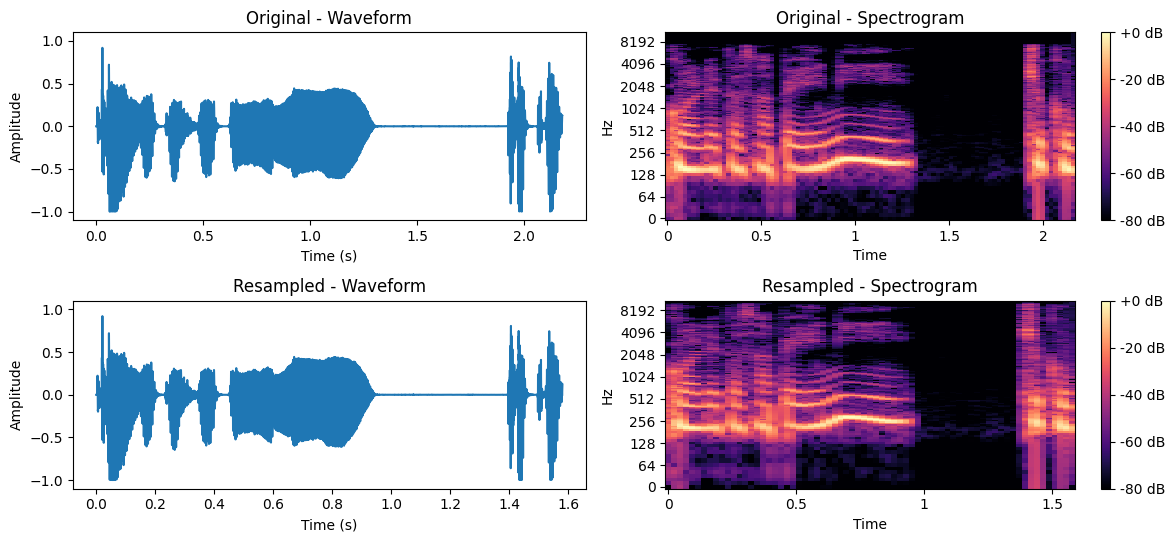

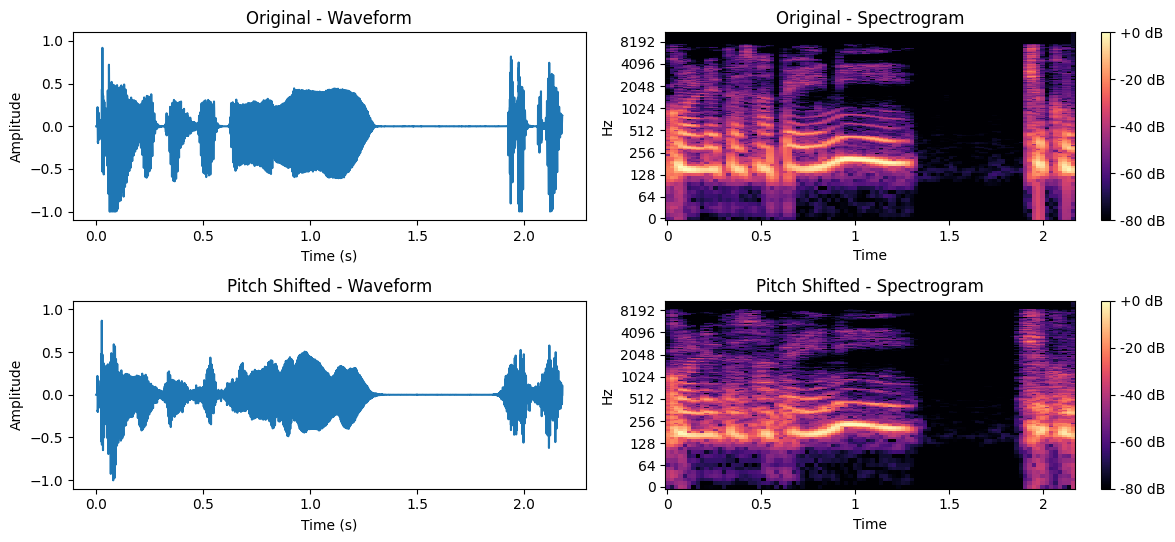

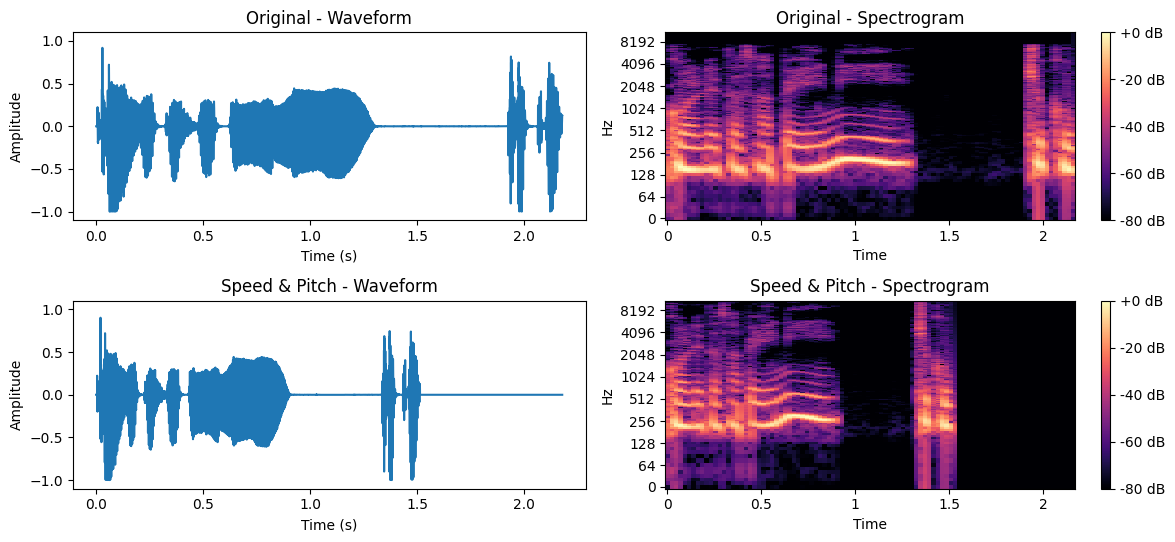

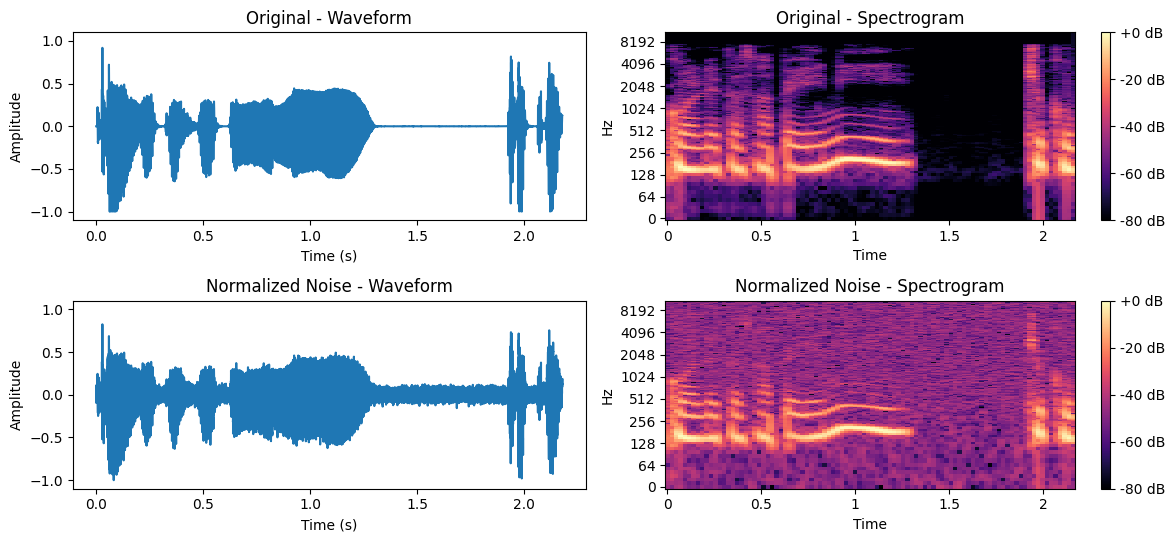

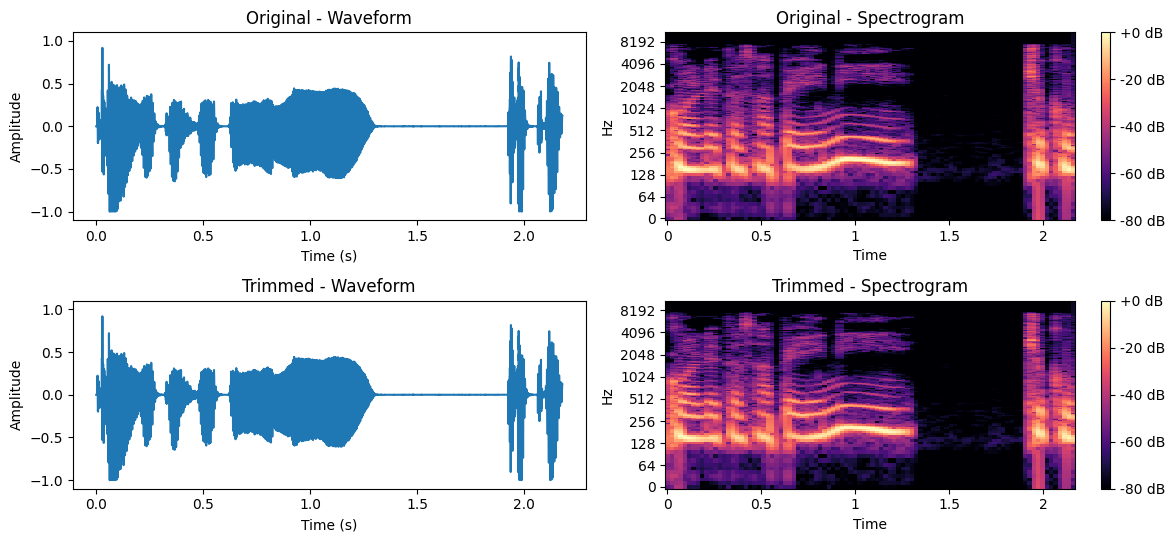

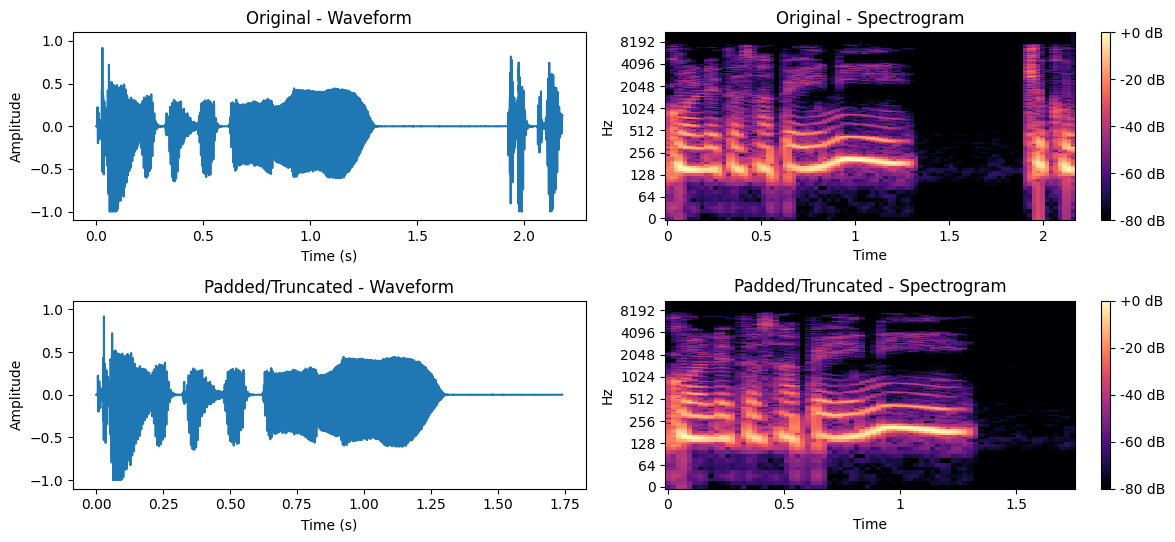

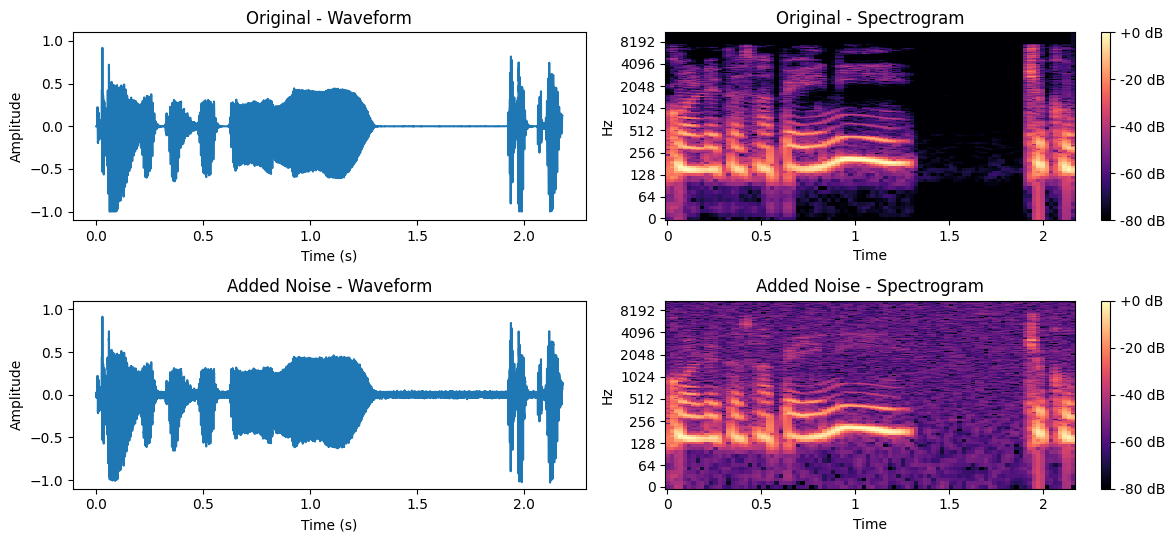

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np

def visualize_audio_augmentations(audio_path, target_samples=48000):
    """
    Visualize original audio alongside each augmentation technique
    Each comparison gets its own separate figure
    
    Parameters:
    - audio_path: path to the audio file
    - target_samples: standardize length for visualization (3s at 16kHz)
    
    Returns:
    - List of figures, one for each augmentation compared with original
    """
    # Load and preprocess audio
    print(f"Loading audio from: {audio_path}")
    audio, sample_rate = librosa.load(audio_path)
    audio = convert_to_mono(audio)
    audio = normalize_audio(audio)
    audio = trim_audio(audio)
    audio = pad_or_truncate(audio, target_samples)
    
    # Store the original audio for comparison
    original_audio = audio.copy()
    
    # Define augmentations with proper labels
    augmentations = [
        ('Original', lambda x: x),
        ('Added Noise', lambda x: noise(x)),
        ('Resampled', lambda x: resample_audio(x, sample_rate)),
        ('Pitch Shifted', lambda x: pitch_shift(x, sample_rate)),
        ('Speed & Pitch', lambda x: speedNpitch(x)),
        ('Normalized Noise', lambda x: normalize_audio(noise(x))),
        ('Trimmed', lambda x: trim_audio(x)),
        ('Padded/Truncated', lambda x: pad_or_truncate(x, int(target_samples*0.8)))
    ]
    
    figures = []
    
    # Create a separate figure for each augmentation (except original)
    for i, (label, augment_func) in enumerate(augmentations):
        if i == 0:  # Skip creating a comparison for Original vs Original
            continue
            
        # Create new figure for this comparison
        fig = plt.figure(figsize=(12, 6))
        
        # Apply augmentation
        aug_audio = augment_func(audio.copy())
        
        # Waveform plots - Original vs Augmented
        ax1 = plt.subplot(2, 2, 1)
        time_orig = np.linspace(0, len(original_audio)/sample_rate, len(original_audio))
        ax1.plot(time_orig, original_audio)
        plt.title('Original - Waveform')
        plt.ylim([-1.1, 1.1])
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        
        ax2 = plt.subplot(2, 2, 3)
        time_aug = np.linspace(0, len(aug_audio)/sample_rate, len(aug_audio))
        ax2.plot(time_aug, aug_audio)
        plt.title(f'{label} - Waveform')
        plt.ylim([-1.1, 1.1])
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        
        # Spectrogram plots - Original vs Augmented
        ax3 = plt.subplot(2, 2, 2)
        D_orig = librosa.amplitude_to_db(np.abs(librosa.stft(original_audio)), ref=np.max)
        img1 = librosa.display.specshow(D_orig, sr=sample_rate, x_axis='time', y_axis='log', ax=ax3)
        fig.colorbar(img1, ax=ax3, format='%+2.0f dB')
        plt.title('Original - Spectrogram')
        
        ax4 = plt.subplot(2, 2, 4)
        D_aug = librosa.amplitude_to_db(np.abs(librosa.stft(aug_audio)), ref=np.max)
        img2 = librosa.display.specshow(D_aug, sr=sample_rate, x_axis='time', y_axis='log', ax=ax4)
        fig.colorbar(img2, ax=ax4, format='%+2.0f dB')
        plt.title(f'{label} - Spectrogram')
        
        # plt.suptitle(f'Comparison: Original vs {}', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        figures.append(fig)
    
    return figures

# Use the first file path from the DataFrame
first_audio_path = df['filepath'].iloc[0]  # Gets the filepath from the first row
print(f"Visualizing audio: {first_audio_path}")

# Create the visualizations
figs = visualize_audio_augmentations(first_audio_path)

# Display each figure
for i, fig in enumerate(figs):
    # You can save individual figures if needed
    # fig.savefig(f'audio_comparison_{i+1}.png', dpi=300)
    plt.figure(fig.number)
    plt.show()

In [9]:
# extract the feature using mfcc
extract_res = []
def mfcc_features(data, target_samples=48000):  # 48000 samples = 3 seconds at 16kHz
    try:
        for index, row in data.iterrows():
            # Load audio and preprocess
            audio, sample_rate = librosa.load(row['filepath'])
            audio = convert_to_mono(audio)  # Ensure mono
            audio = normalize_audio(audio)  # Normalize audio
            audio = trim_audio(audio)  # Trim silence
            audio = pad_or_truncate(audio, target_samples)  # Standardize length
            
            mfcc_def = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)

            augmentations = [
                lambda x: noise(x),
                lambda x, sr=sample_rate: resample_audio(x, sr),
                lambda x: speedNpitch(x),
                lambda x: normalize_audio(noise(x)),
            ]

            extract_res.append({
                'emotion': row['emotion'],
                'filepath': row['filepath'],
                'features': mfcc_def
            })

            for aug in augmentations:
                augmented_data = aug(audio)
                augmented_data = pad_or_truncate(augmented_data, target_samples)
                mfccs = np.mean(librosa.feature.mfcc(y=augmented_data, sr=sample_rate, n_mfcc=40).T, axis=0)
                
                extract_res.append({
                    'emotion': row['emotion'],
                    'filepath': row['filepath'],
                    'features': mfccs
                })
        return extract_res
    except Exception as e:
        logging.error(f"Error {e} encountered while parsing file: {row['filepath']}")
        return None

In [10]:
features = mfcc_features(df)
df_features = pd.DataFrame(features)

In [11]:
df_features.to_csv('../data/features.csv', index=False)
df_features.head()

,emotion,filepath,features
0,sad,../data/processed_audio/Actor_07/07-05-01-01.wav,"[-312.13492, 96.06893, 10.050451, 47.73297, -1..."
1,sad,../data/processed_audio/Actor_07/07-05-01-01.wav,"[-156.41651202157226, 43.51450291415993, 22.07..."
2,sad,../data/processed_audio/Actor_07/07-05-01-01.wav,"[-341.71177663737546, 61.940462649632195, 15.2..."
3,sad,../data/processed_audio/Actor_07/07-05-01-01.wav,"[-330.3487, 76.34677, 13.045647, 25.350351, -2..."
4,sad,../data/processed_audio/Actor_07/07-05-01-01.wav,"[-138.81899312774598, 32.73223485793847, 17.61..."


### Modelling

In [12]:
label_encoder = LabelEncoder()

X = np.array(df_features['features'].tolist())
y = label_encoder.fit_transform(df_features['emotion'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

In [ ]:
columns = ['class_name', 'class_code']
class_names = pd.DataFrame(columns=columns)
class_names['class_name'] = label_encoder.classes_
class_names['class_code'] = label_encoder.transform(label_encoder.classes_)

class_names.to_csv('../saves/model/class_names.csv', index=False)

In [27]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (1200, 40, 1)
X_test shape: (300, 40, 1)


In [15]:
# Define the model
model = Sequential()
model.add(Dense(1024, input_shape=(X_train.shape[1],), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(len(np.unique(y)), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])

/home/reiaslite/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-26 19:38:12.138179: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │        41,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 739,333 (2.82 MB)

 Trainable params: 735,493 (2.81 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [17]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15)
model_checkpoint = ModelCheckpoint('../saves/model/best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint], verbose=1)

Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.2402 - loss: 2.1299 - val_accuracy: 0.2867 - val_loss: 3.2642
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3708 - loss: 1.6225 - val_accuracy: 0.3600 - val_loss: 1.5240
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4244 - loss: 1.3962 - val_accuracy: 0.4367 - val_loss: 1.3539
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4314 - loss: 1.3873 - val_accuracy: 0.5233 - val_loss: 1.0549
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4974 - loss: 1.2600 - val_accuracy: 0.4533 - val_loss: 1.1474
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5011 - loss: 1.2616 - val_accuracy: 0.5300 - val_loss: 1.0582
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5436 - loss: 1.1312 - val_accuracy: 0.5633 - val_loss: 1.0079
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5398 - loss: 1.0548 - val_accuracy: 0.5333 - 

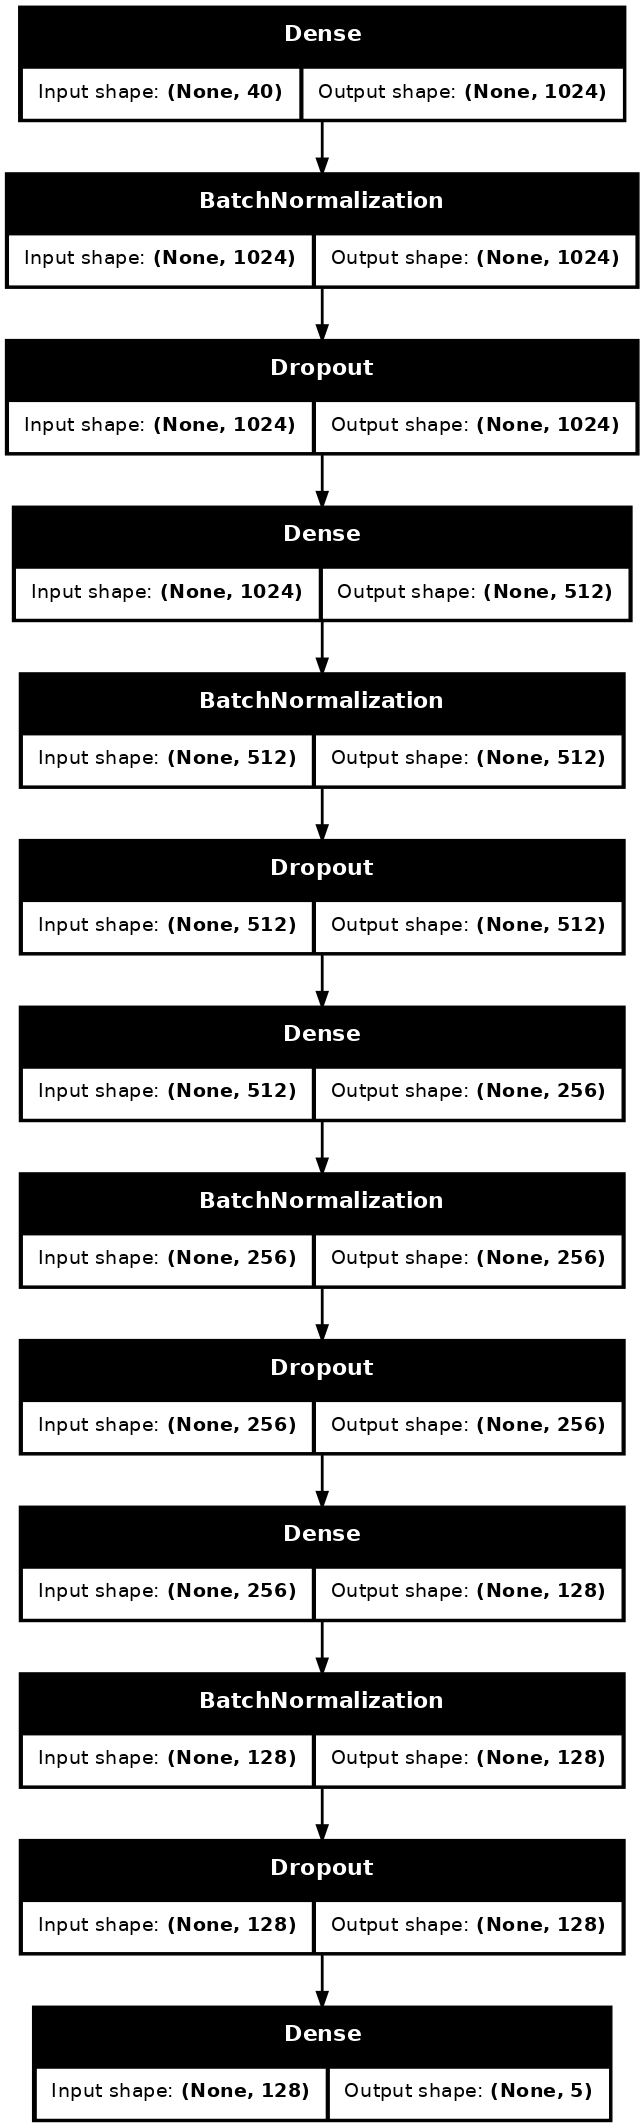

In [ ]:
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report

# 1. Visualisasi Arsitektur Model
# Visualisasi struktur model secara grafis
plot_model(model, 
           to_file='../saves/model_architecture.png', 
           show_shapes=True, 
           dpi=100, rankdir='TB')


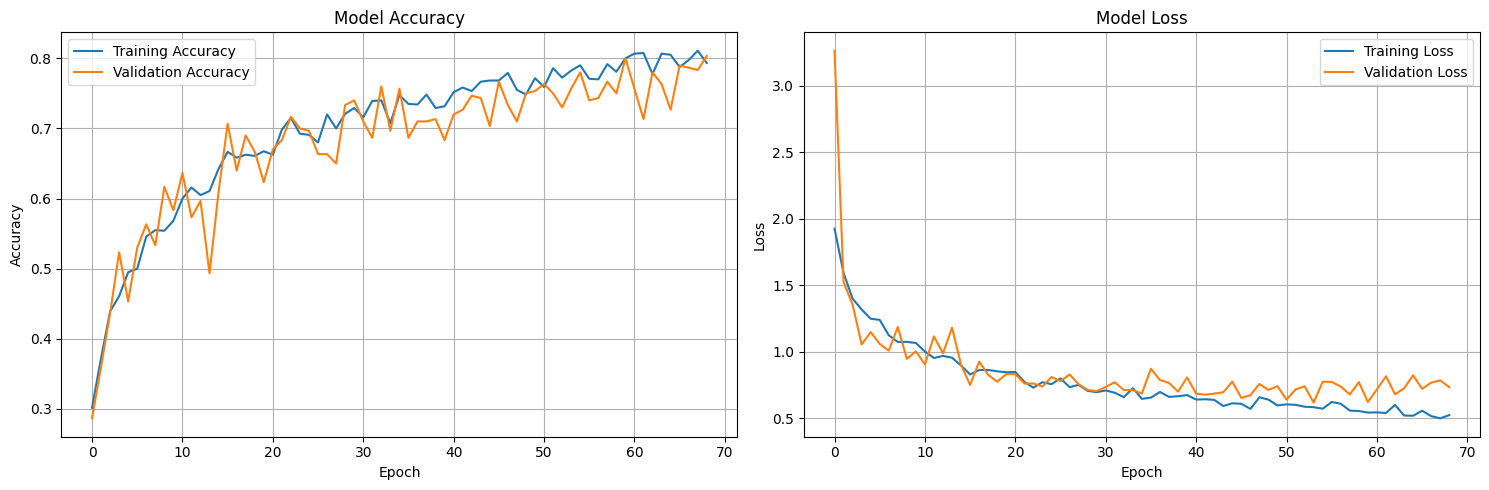

In [19]:
# 2. Visualisasi Riwayat Pelatihan
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot akurasi
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('../saves/training_history.png', dpi=300)
    plt.show()

# Panggil fungsi setelah pelatihan model
plot_training_history(history)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


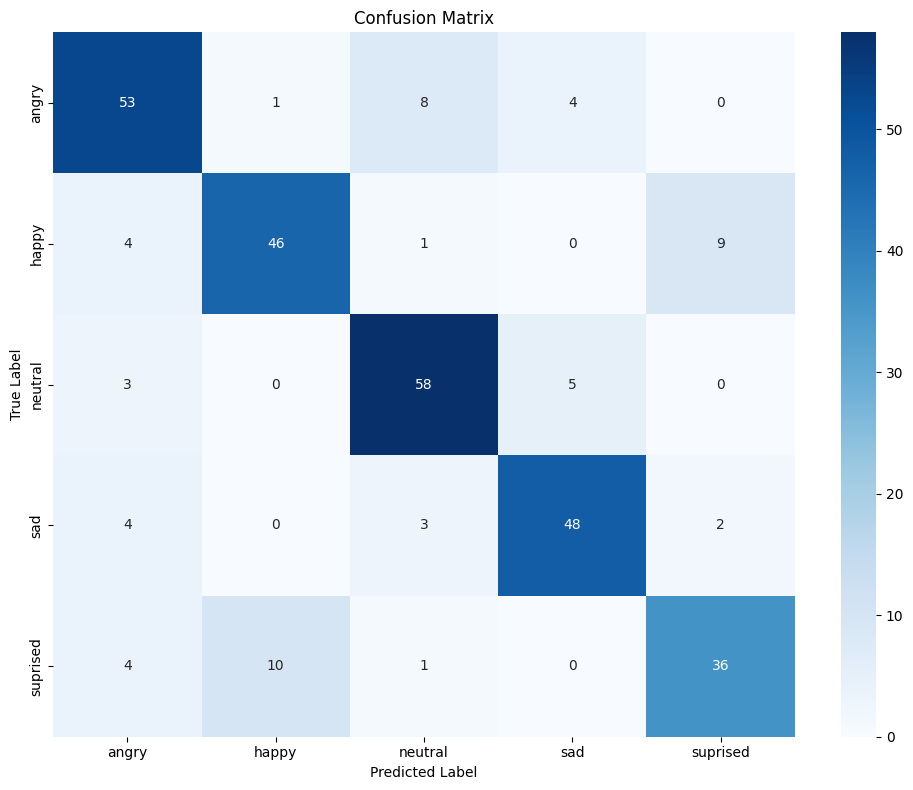

              precision    recall  f1-score   support

       angry       0.78      0.80      0.79        66
       happy       0.81      0.77      0.79        60
     neutral       0.82      0.88      0.85        66
         sad       0.84      0.84      0.84        57
    suprised       0.77      0.71      0.73        51

    accuracy                           0.80       300
   macro avg       0.80      0.80      0.80       300
weighted avg       0.80      0.80      0.80       300



In [20]:
# 3. Visualisasi Matriks Konfusi
def plot_confusion_matrix():
    # Prediksi dengan model terlatih
    y_pred = np.argmax(model.predict(X_test), axis=1)
    
    # Hitung matriks konfusi
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot matriks konfusi dengan seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('../saves/confusion_matrix.png', dpi=300)
    plt.show()
    
    # Cetak laporan klasifikasi
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

plot_confusion_matrix()


In [23]:
# Get predictions
y_pred = model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate accuracy
test_accuracy = np.sum(y_pred_classes == y_test) / len(y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Test Accuracy: 80.33%
